# Two hyperplanes trading bot

## Model
$x(t) \in \mathbb{R}^n$ represent the n-dimension curve, which means the feature of market at time $t$.

There are two planes  ${w}^T(x-p)=0$ and ${u}^T(x-q)=0$ called trading planes, which partition $\mathbb{R}^n$ into 4 regions.
$${w}^T(x-p)>=0 \; and \; {u}^T(x-q)>=0 : Buy\;region $$
$${w}^T(x-p)>=0 \; and \; {u}^T(x-q)<0 : Hold\;region $$
$${w}^T(x-p)<0 \; and \; {u}^T(x-q)<0 : Sell\;region $$
$${w}^T(x-p)<0 \; and \; {u}^T(x-q)>=0 : Hold\;region $$

## Estimate
To determine the two hyperplanes, we need to uniquely determine the unit normal vector ${w}$, ${u}$ and shift ${p}$, ${q}$.  The philosophy of the strategy is $x(t)$ oscillate in feature space like the market.  The center point should be choose as the average of the feature space, denoted by ${p}^*$

So the two hyperplanes are modelde as ${w}^T(x-{p}^*)$ and ${u}^T(x-{p}^*)$.  The next step is to determine the two unit vector ${w}$ and ${u}$.  Let's use [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES)

## Action and Objective
The definition of objective function can be set as $$r - {\lambda} \times \frac{\sigma^2}{2}$$
$r$ represent the annualized return, $\sigma$ is the annualized downward volatility, $\lambda$ is the panelty of the downward volatility.  For a given period $[0, T]$, there are serveral simple mode to help calculate the loss function:
- Spot mode:
  - Initial fund is 50%, 50% of the asset of token, USDT.
  - Once $x(t)$ first enter buy space, use all USDT to buy token.  Otherwise, sell all token to USDT
- Perp mode (1):
  - Initial position is 0
  - Once $x(t)$ first enter buy space, enter long position with position 1, Hold until $x(t)$ enter sell space and reverse the position
- Perp model (2):
  - Initial position is 0
  - Once $x(t)$ is in buy space, the position is 1.  Else if $x(t)$ is in hold space, position is 0, else $x(t)$ is in sell space, the position is -1.


## MLOps
To identify the effectiveness, there should be a series of MLOps for time-series, let's skip this part and address in next notebook.

## Risk management
Skip first and will address in the future notebook

## Backtest and Production
After finding the two hyperplanes, we can determine the actual strategy by study the geometry to elaborate the parameters like quantity, or the strength of the signal to determine whether we can buy or skip the buy.  Some geometry are list below:
$$\frac{d}{dt} x(t) \;tangent\;of\;x(t)$$
$$\left\| \frac{d}{dt} x(t) \right\| \;speed\;of\;x(t)$$
$$\int_{a}^{b} \left\| \frac{d\mathbf{x}}{dt} \right\| \, dt\;arc length\;of\;x(t)$$
and other geometry like period of a buy-sell cycle, projection from $x(t)$ to buy/sell planes, etc

## Report
A report should contains some MLOps statistics, but we can still deliver some financial index like: return, volatility, MDD and sharpe ratio for reference.
In spot, we can benchmark the portfolio with holding BTC, holding ETH.



# Finding Hyperplanes


In [25]:
# The load hourly data from 2023-05-01 00:00:00 to 2023-10-30 23:59:59 because this peroid is diversified enough and we test from 2023-11-01 00:00:00 to 2024-2-28 23:59:59
from backtest.components.core import ZipKLineIterator
from backtest.components import KLineMarket

from datetime import datetime, timezone
import pandas as pd

start_time = datetime(2023, 4, 1, tzinfo=timezone.utc).timestamp() * 1000  # Load one month in advance to do feature engineering
end_time = datetime(2023, 11, 1, tzinfo=timezone.utc).timestamp() * 1000 - 1
data_source = '/home/yite/crypto_data/binance/data'
kline_iterator = ZipKLineIterator('BTCUSDT', start_time, end_time, data_source)
df = kline_iterator.to_dataframe()
df = df[["open", "high", "low", "close", "volume", "open_time", "close_time"]]
df['date'] = pd.to_datetime(df['open_time'], unit='ms')
df.set_index('date', inplace=True)


In [26]:
# Feature Engineering, here use MACD in TaLib
import talib
help(talib.MACD)

Help on function MACD in module talib._ta_lib:

MACD(real, fastperiod=-2147483648, slowperiod=-2147483648, signalperiod=-2147483648)
    MACD(real[, fastperiod=?, slowperiod=?, signalperiod=?])
    
    Moving Average Convergence/Divergence (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        fastperiod: 12
        slowperiod: 26
        signalperiod: 9
    Outputs:
        macd
        macdsignal
        macdhist



In [27]:
df['macd'], df['macdsignal'], _ = talib.MACD(df['close'])

In [28]:
start_date = '2023-05-01 00:00:00'
end_date = '2023-10-30 23:59:59'

# Querying the DataFrame
df = df.loc[start_date:end_date]
df

,open,high,low,close,volume,open_time,close_time,macd,macdsignal
date,,,,,,,,,
2023-05-01 00:00:00,29233.20,29337.34,29215.93,29315.57,1884.84043,1682899200000,1682902799999,24.442366,43.546333
2023-05-01 01:00:00,29315.57,29315.57,28369.95,28504.36,7975.68782,1682902800000,1682906399999,-46.699682,25.497130
2023-05-01 02:00:00,28504.36,28680.38,28414.00,28549.41,4047.55713,1682906400000,1682909999999,-98.311831,0.735338
2023-05-01 03:00:00,28549.42,28592.95,28436.27,28561.06,2058.76530,1682910000000,1682913599999,-136.698993,-26.751528
2023-05-01 04:00:00,28561.07,28589.84,28486.29,28555.00,1378.42285,1682913600000,1682917199999,-165.700000,-54.541223
...,...,...,...,...,...,...,...,...,...
2023-10-30 19:00:00,34314.00,34439.83,34285.80,34432.11,947.64111,1698692400000,1698695999999,25.190944,47.504445
2023-10-30 20:00:00,34432.12,34438.45,34320.00,34414.96,886.05294,1698696000000,1698699599999,20.038138,42.011184
2023-10-30 21:00:00,34414.95,34569.68,34359.90,34528.58,836.92408,1698699600000,1698703199999,24.836388,38.576224


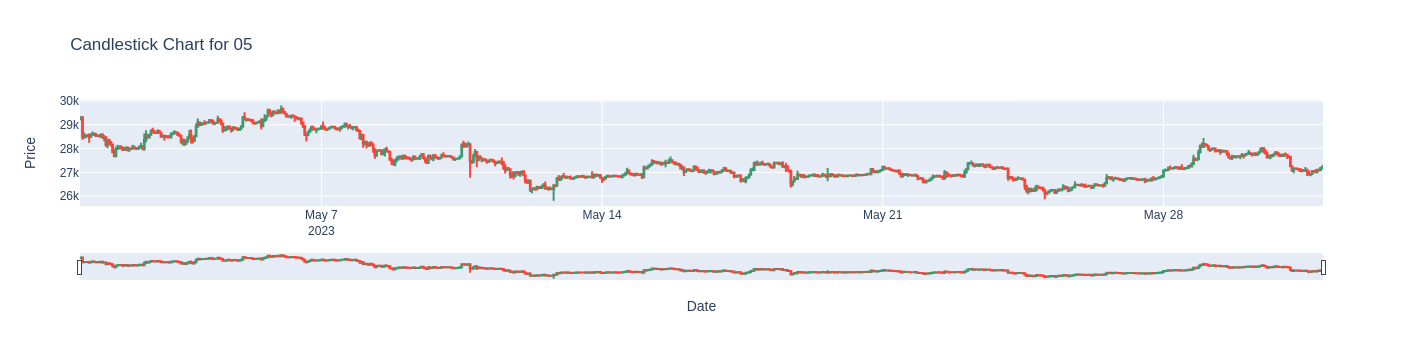

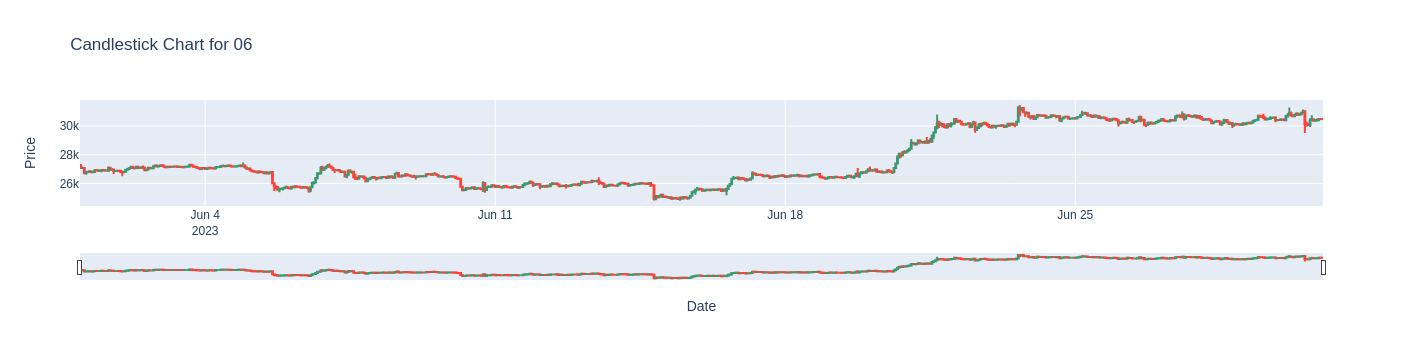

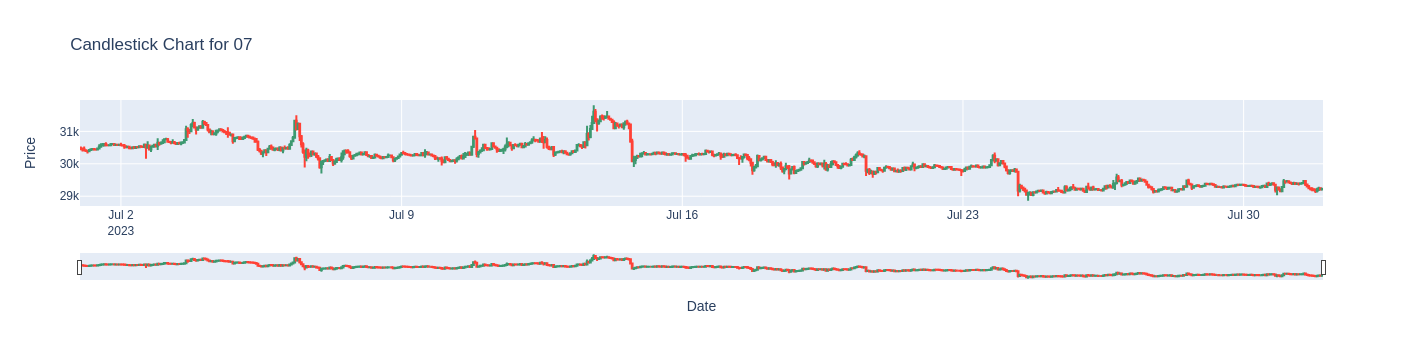

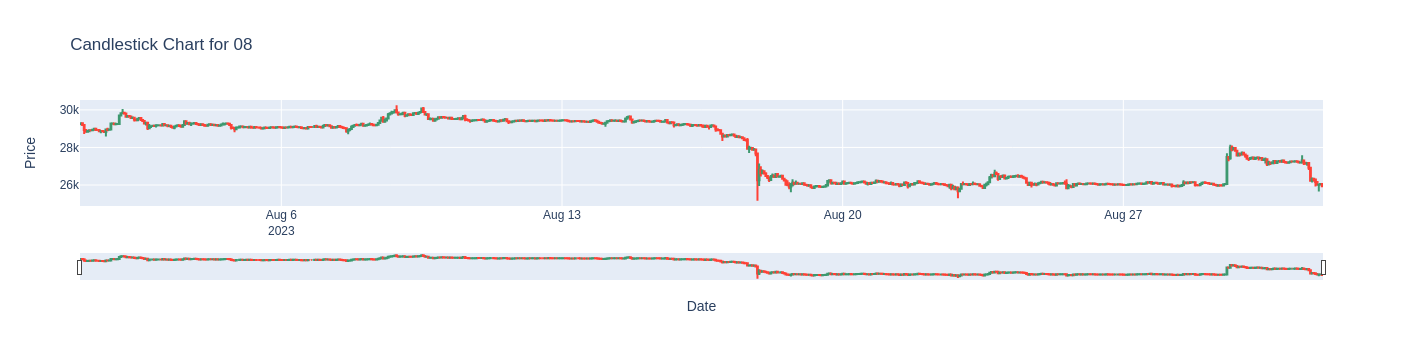

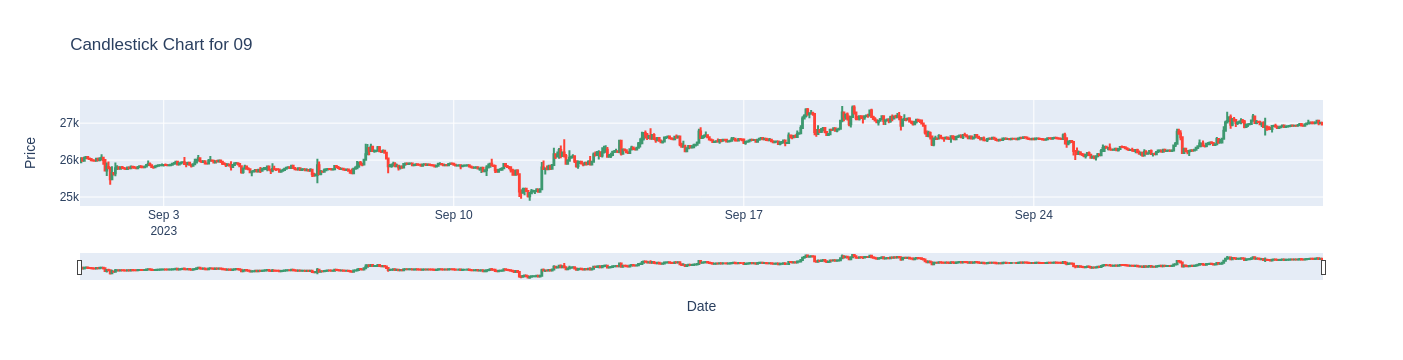

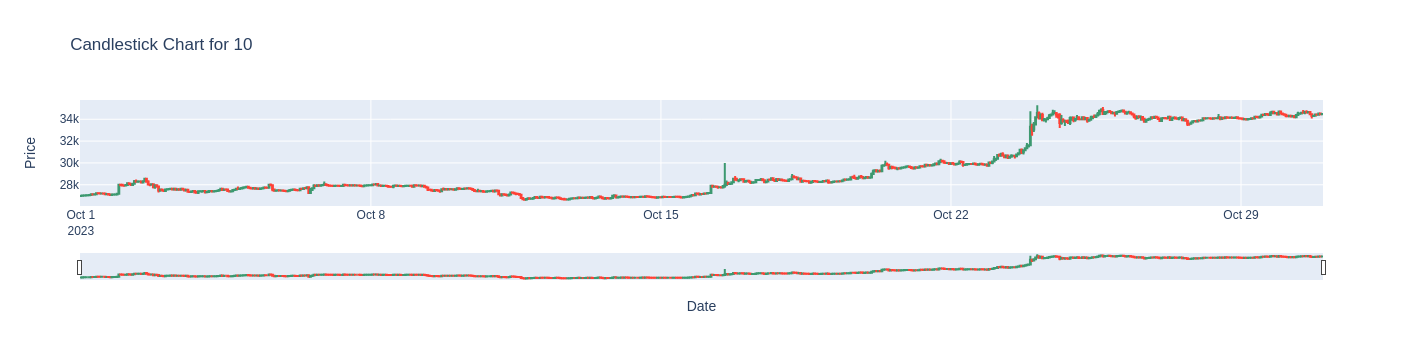

In [30]:
import plotly.graph_objects as go

months = df.index.month.unique()
for month in months:
    # Filter data for the specific month and year
    monthly_data = df[(df.index.month == month)]
    # Check if there is data for the month
    if not monthly_data.empty:
        # Create a candlestick chart for the month
        fig = go.Figure(data=[go.Candlestick(x=monthly_data.index,
                                             open=monthly_data['open'],
                                             high=monthly_data['high'],
                                             low=monthly_data['low'],
                                             close=monthly_data['close'])])
        # Update layout with the title indicating the month and year
        fig.update_layout(title=f'Candlestick Chart for {month:02d}',
                          xaxis_title='Date',
                          yaxis_title='Price')
        # Show the plot
        fig.show()

In [38]:
import numpy as np
# Determine p*
# p = np.array([df['macd'].median(), df['macdsignal'].median()])
p = np.array([df['macd'].mean(), df['macdsignal'].mean()])

p

array([8.12499601, 8.13895374])

In [73]:
# Prepare objective function
import numpy as np
from backtest.ffn import calc_interval_return, calc_interval_volatility

def spot_strategy(strategy: pd.DataFrame):
    eps = 1e-5
    asset = {'token': 1_000 / strategy['open'].iloc[0], 'usdt': 1_000}
    portfolio = []
    for idx, event in strategy.iterrows():
        price = event["close"]
        if event["strategy"] == "Hold":
            pass
        elif asset['usdt'] > eps and event["strategy"] == "Buy":
            usdt_amt = asset['usdt']
            btc_amt = usdt_amt / price
            asset['token'] += btc_amt
            asset['usdt'] -= usdt_amt
        elif asset['token'] > eps / price and event["strategy"] == "Sell":
            btc_amt = asset['token']
            usdt_amt = btc_amt * price
            asset['token'] -= btc_amt
            asset['usdt'] += usdt_amt
        portfolio.append({"open_time": event["open_time"]} | asset | {"value": asset["token"] * price + asset["usdt"]})
    portfolio = pd.DataFrame(portfolio)
    r = calc_interval_return(portfolio, 'open_time', 'value', '365d')
    v = calc_interval_volatility(portfolio, 'open_time', 'value', '365d')
    return r, v
    

def objective_function(u: np.array, v: np.array, p: np.array, q: np.array, market: pd.DataFrame, *features): # u, v are normal vector and 
    df = market.copy()
    df['buy'] = df[list(features)] @ u
    df['sell'] = df[list(features)] @ v
    df['buy_signal'] = df['buy'] > 0
    df['sell_signal'] = df['sell'] > 0
    # Apply logic to create strategy column
    df['strategy'] = df.apply(
        lambda row: "Buy" if row['buy_signal'] == True and row['sell_signal'] == False 
                    else ("Sell" if row['buy_signal'] == False and row['sell_signal'] == True 
                          else "Hold"), 
        axis=1
    )
    r, v = spot_strategy(df)
    return r, v
    

In [74]:
u = np.array([1, 0])
v = np.array([0, 1])
objective_function(u, v, p, p, df, 'macd', 'macdsignal')

(-0.11411087399423617, 0.2242856774045553)

In [59]:
df['open'].iloc[0]

29233.2